In [1]:

import os
import sys
import importlib
import copy
from collections import defaultdict
sys.path.insert(0, '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc')

from tools_pattern import get_eucledean_dist

# script_n = os.path.basename(__file__).split('.')[0]
script_n = 'distribution_123share_210512_dist'

import my_plot
importlib.reload(my_plot)
from my_plot import MyPlotData, my_box_plot

def to_ng_coord(coord):
    return (
        int(coord[0]/4),
        int(coord[1]/4),
        int(coord[2]/40),
        )

import compress_pickle

# input_graph = compress_pickle.load('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/'\
#                                    'mf_grc_model/input_graph_201114_restricted_z.gz')
fname = ('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/'\
#                                    'mf_grc_model/input_graph_210407_xlim_90_140_zlim_0.0_44.0.gz')
                                   'mf_grc_model/input_graph_210407_all.gz')
input_graph = compress_pickle.load(fname)

# z_min = 19800
# z_max = 29800
z_min = 19800-2500
z_max = 29800+2500
# GrCs are fully reconstructed and proofread from 90k to 150k
x_min = 100*1000*4
x_max = 140*1000*4
# radius = 200

n_randoms = 5
replication_hist2 = defaultdict(int)
grc_ids = set()
mf_ids = set()
replicated_2shares = defaultdict(int)
dist_hist = []

def get_prob(in_graph, unique_count=False, count_within_box=True, return_counted=False):
    n_common_pairs = 0
    processed = set()
    total_n_pairs = 0
    hist = defaultdict(int)
    n = 0
    counted_grcs = 0
    for grc_i_id in in_graph.grcs:
        n += 1
        grc_i = in_graph.grcs[grc_i_id]
        x, y, z = grc_i.soma_loc
        if count_within_box:
            if x < x_min or x > x_max:
                continue
            if z < z_min or z > z_max:
                continue
        counted_grcs += 1
        grc_ids.add(grc_i_id)
        rosettes_i = set([mf[0] for mf in grc_i.edges])
        for r in rosettes_i:
            mf_ids.add(r)
        for grc_j_id in in_graph.grcs:
            if grc_i_id == grc_j_id:
                continue
            if unique_count and (grc_i_id, grc_j_id) in processed:
                continue
            processed.add((grc_i_id, grc_j_id))
            processed.add((grc_j_id, grc_i_id))
            grc_j = in_graph.grcs[grc_j_id]
            x, y, z = grc_j.soma_loc
#             if count_within_box:
#                 if x < x_min or x > x_max:
#                     continue
#                 if z < z_min or z > z_max:
#                     continue
            common_rosettes = set([mf[0] for mf in grc_j.edges])
            common_rosettes = common_rosettes & rosettes_i
            hist[len(common_rosettes)] += 1
            if len(common_rosettes) == 2:
                replication_hist2[grc_i_id] += 1
                common_rosettes = tuple(sorted(list(common_rosettes)))
                replicated_2shares[common_rosettes] += 1
            if len(common_rosettes) >= 2:
                dist = get_eucledean_dist(grc_i.soma_loc, grc_j.soma_loc)
                dist = int(dist/1000+.5)
                dist_hist.append(dist)
    for k in hist:
        # fix 0 datapoint plots
        if hist[k] == 0:
            hist[k] = 1
    if return_counted:
        return hist, counted_grcs
    else:
        return hist

input_observed = copy.deepcopy(input_graph)


# input_observed.randomize_graph_by_grc2(
# #     constant_dendrite_length='depth',
#     mf_dist_margin=5000,
#     seed=1,
# )

input_observed.edge_probabilities_by_pos = None
input_observed.shuffle_edges(
    seed=1,
#     max_edge_len=60000,
#     mf_dist_margin=10000,
    )

hist_data, n_grcs = get_prob(input_observed, count_within_box=True, return_counted=True)

print(n_grcs)
print(hist_data)
print(len(mf_ids))
# n_grcs = len(input_graph.grcs)

409
defaultdict(<class 'int'>, {0: 987838, 1: 32716, 2: 1099, 3: 29})
328


In [2]:

norm = 1612

def calc_mpd(input_data, kind):
    mpd = MyPlotData()
    for n, distances in enumerate(input_data):
        hist = defaultdict(int)
        mpd_trial = MyPlotData()
#         print(distances)
        for d in distances:
            # mpd.add_data_point(
            #     dist=d,
            #     kind='Naive Random',
            #     trial=n,
            #     )
            hist[d] += 1
        # for d in sorted(hist.keys()):
        for d in range(max(hist.keys())):
            mpd_trial.add_data_point(
                dist=d,
                count=hist[d],
                kind=kind,
                trial=n,
            )
#         mpd_trial = mpd_trial.to_pdf('count', cumulative=True, fixed_scale=norm)
        mpd_trial = mpd_trial.add_pdf('count', cumulative=True)
        mpd.append(mpd_trial)
    return mpd

mpd = calc_mpd([dist_hist], kind='Data')

Height: 4, Aspect: 1.25


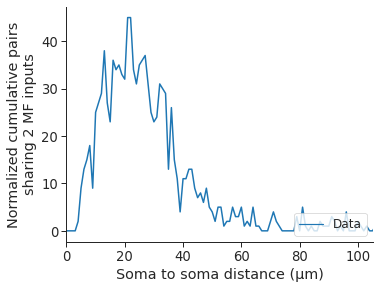

In [5]:

def custom_legend_fn(plt):
#     plt.legend(bbox_to_anchor=(1.025, .8), loc='upper left', borderaxespad=0.)
    plt.legend(loc='lower right', frameon=True, fontsize=12)

# mpd_total = MyPlotData()
# for label in labels:
#     mpd_total.append(mpd_data[label])
# mpd_total.append(mpd_naive)
# mpd_total.append(mpd_random_correct)

importlib.reload(my_plot); my_plot.my_relplot(
    mpd,
    x='dist',
#     y='count_pdf',
    y='count',
    hue='kind',
    kind='line',
    ci='sd',
    # stat="density",
    # kde=True,
    # hue_order=['Data', 'Shuffle'],
    context='paper',
#     xlim=(None, 60),
    xlim=(0, 105),
#     ylim=[0, 1.01],
    height=4,
    aspect=1.25,
    y_axis_label='Normalized cumulative pairs\nsharing 2 MF inputs',
    x_axis_label='Soma to soma distance (μm)',
    save_filename=f'{script_n}.svg',
    show=True,
    custom_legend_fn=custom_legend_fn,
#     tight_layout=True,
#     tight_layout=False,
#     old_tight_layout=True,
    )

